# Training from scratch with a LeNet-like architecture

### Import the CIFAR10 dataset 

In [5]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

### Examine the dataset

In [6]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_test)) 
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


5


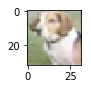

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import random
index = random.randint(0, n_train)
image = X_train[index]
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

(array([ 5000.,  5000.,  5000.,  5000.,  5000.,  5000.,  5000.,  5000.,
         5000.,  5000.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

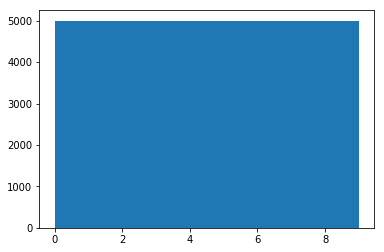

In [8]:
import numpy as np
X_train = -1 + 2*(X_train/255)
X_test = -1 + 2*(X_test/255)
plt.hist(y_train, bins=n_classes)

### Create training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Define the CNN architecture

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 800. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc0, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout Layer 
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
     # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Dropout Layer 
    #fc3 = tf.nn.dropout(fc3, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (10).
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Define training and evaluation operations

In [12]:
from sklearn.utils import shuffle

# Learning rate
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train the CNN

In [13]:
EPOCHS = 50
BATCH_SIZE = 512

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.371

EPOCH 2 ...
Validation Accuracy = 0.451

EPOCH 3 ...
Validation Accuracy = 0.502

EPOCH 4 ...
Validation Accuracy = 0.526

EPOCH 5 ...
Validation Accuracy = 0.544

EPOCH 6 ...
Validation Accuracy = 0.549

EPOCH 7 ...
Validation Accuracy = 0.567

EPOCH 8 ...
Validation Accuracy = 0.585

EPOCH 9 ...
Validation Accuracy = 0.597

EPOCH 10 ...
Validation Accuracy = 0.598

EPOCH 11 ...
Validation Accuracy = 0.608

EPOCH 12 ...
Validation Accuracy = 0.619

EPOCH 13 ...
Validation Accuracy = 0.626

EPOCH 14 ...
Validation Accuracy = 0.626

EPOCH 15 ...
Validation Accuracy = 0.635

EPOCH 16 ...
Validation Accuracy = 0.629

EPOCH 17 ...
Validation Accuracy = 0.646

EPOCH 18 ...
Validation Accuracy = 0.641

EPOCH 19 ...
Validation Accuracy = 0.648

EPOCH 20 ...
Validation Accuracy = 0.649

EPOCH 21 ...
Validation Accuracy = 0.646

EPOCH 22 ...
Validation Accuracy = 0.653

EPOCH 23 ...
Validation Accuracy = 0.648

EPOCH 24 ...
Validation Accura

### Test the model

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.663
